### II: EDA

In this notebook, I will be performing Exploratory Data Analysis on the body landmark data points collected in Notebook I. The goals for this notebook are:
1) Simplify the 33 data landmark points into laymen terms to see how they are related to human posture analysis (will be shown via statistical analysis, image overlays)
2) Understand the key differentiators between a good and bad posture, for e.g. what angles between which landamarks are useful in determining a good posture.
3) Eventually, understand which landmark data points might be selected as features during modelling to determine a good posture.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp
import seaborn as sns
import cv2
import glob
import os


#### 1. Example of Good and Bad Postures: <br>

<img src="images/run-walk-posture.jpg"  style="height:400px" />


In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

In [5]:
df_bad = pd.read_csv('Pose_keypoints_bad.csv')
df_bad.head()

df_good = pd.read_csv('Pose_keypoints_good.csv')
df_good.head()

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z31,v31,x32,y32,z32,v32,x33,y33,z33,v33
0,Good,0.427481,0.432218,0.187747,0.999349,0.433324,0.424074,0.148867,0.998281,0.434497,...,0.229658,0.889561,0.670334,0.664551,-0.064846,0.988610,0.474645,0.799503,0.198858,0.913017
1,Good,0.427867,0.424335,0.103592,0.999405,0.435398,0.416132,0.074502,0.998436,0.436960,...,0.171699,0.896321,0.646353,0.702969,-0.049465,0.989388,0.574099,0.800178,0.147779,0.918380
2,Good,0.437734,0.413582,0.081666,0.999456,0.443536,0.406205,0.056616,0.998587,0.445162,...,-0.332621,0.904731,0.526356,0.725758,-0.026678,0.989607,0.674077,0.800791,-0.391390,0.925486
3,Good,0.441794,0.404654,0.074183,0.999448,0.448542,0.397865,0.044298,0.998694,0.450451,...,-0.278002,0.912920,0.418003,0.741679,0.014452,0.988432,0.749979,0.780808,-0.335191,0.931552
4,Good,0.444895,0.399103,0.001690,0.999498,0.451033,0.391476,-0.031034,0.998821,0.452720,...,-0.054553,0.921146,0.319029,0.749560,-0.108193,0.988595,0.825690,0.735513,-0.097319,0.937508


In [6]:
df = pd.concat([df_bad, df_good], axis=0, ignore_index=True)
df['good_posture'] = df['class'].apply(lambda x: 1 if x == 'Good' else 0)
df.head()

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,v31,x32,y32,z32,v32,x33,y33,z33,v33,good_posture
0,Bad,0.597514,0.330045,-0.046739,0.999786,0.595233,0.314657,-0.039935,0.999435,0.594381,...,0.986479,0.542886,0.811219,0.140850,0.936010,0.519139,0.821335,-0.042727,0.995285,0
1,Bad,0.603381,0.325570,-0.049170,0.999806,0.601188,0.310604,-0.040726,0.999489,0.600242,...,0.985957,0.541942,0.809034,0.138972,0.930692,0.536733,0.821338,-0.048026,0.994957,0
2,Bad,0.614878,0.315903,-0.031407,0.999825,0.613352,0.302009,-0.020730,0.999540,0.612598,...,0.986882,0.542489,0.811047,0.129956,0.932926,0.563722,0.822904,-0.049756,0.995270,0
3,Bad,0.624886,0.308227,-0.035477,0.999842,0.623481,0.295145,-0.026631,0.999585,0.622720,...,0.987635,0.539751,0.811104,0.098917,0.936107,0.592707,0.822877,-0.048756,0.995534,0
4,Bad,0.636889,0.295799,-0.043732,0.999856,0.634686,0.282637,-0.032385,0.999624,0.634024,...,0.988365,0.539935,0.810745,0.093304,0.938698,0.613125,0.822549,-0.048148,0.995753,0


In [7]:
df.describe()

,x1,y1,z1,v1,x2,y2,z2,v2,x3,y3,...,v31,x32,y32,z32,v32,x33,y33,z33,v33,good_posture
count,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,...,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000
mean,0.489351,0.310098,-0.103770,0.998563,0.489274,0.282535,-0.104224,0.998526,0.490194,0.280996,...,0.598976,0.520475,1.146601,0.134439,0.518633,0.502951,1.192496,0.073281,0.578577,0.486916
std,0.111519,0.114437,0.123013,0.006828,0.112920,0.109781,0.118392,0.006162,0.113140,0.109290,...,0.381817,0.138632,0.451344,0.249888,0.430155,0.139357,0.467792,0.178820,0.403555,0.499859
min,-0.020505,-0.108444,-0.652493,0.805949,-0.013616,-0.126093,-0.640026,0.826938,-0.013492,-0.125314,...,0.000294,0.000066,0.174037,-0.656764,0.000222,-0.000393,0.277891,-0.475098,0.000346,0.000000
25%,0.440504,0.218740,-0.170203,0.999470,0.440400,0.199861,-0.173875,0.999376,0.438440,0.199358,...,0.221141,0.445613,0.827565,-0.063193,0.086904,0.409352,0.839117,-0.072811,0.133204,0.000000
50%,0.486084,0.347536,-0.092988,0.999818,0.483611,0.310313,-0.091452,0.999781,0.485254,0.308803,...,0.783893,0.524063,0.936583,0.134392,0.458614,0.509248,0.962796,0.072277,0.706215,0.000000
75%,0.539146,0.387306,-0.032474,0.999940,0.539671,0.354050,-0.028098,0.999933,0.544214,0.351431,...,0.954697,0.607728,1.407454,0.315183,0.960441,0.588289,1.512669,0.199993,0.967417,1.000000
max,1.039752,0.867214,0.587195,1.000000,1.036630,0.864411,0.540488,0.999999,1.035088,0.864875,...,0.992624,1.015766,2.430448,0.906308,0.999240,1.037150,2.543757,0.817636,0.996433,1.000000


#### 2. Visibility of Landmarks

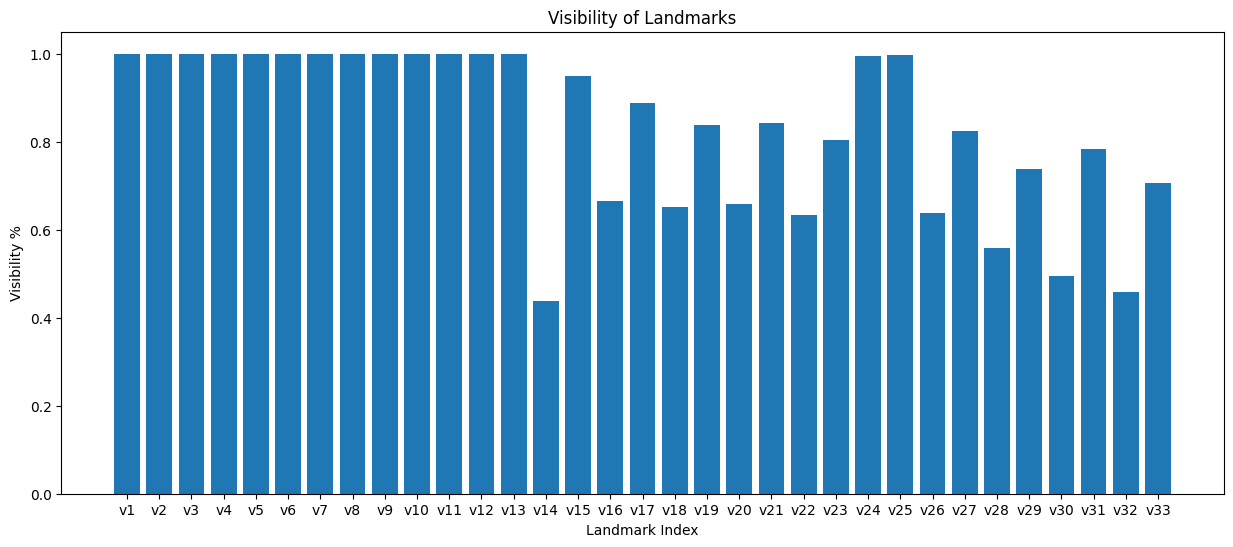

In [8]:
# Bar chart for visibility of landmarks
visibility_columns = df.filter(regex='^v', axis=1)
visibility_counts = visibility_columns.median()
plt.figure(figsize=(15, 6))
plt.bar(visibility_counts.index, visibility_counts.values)
plt.xlabel('Landmark Index')
plt.ylabel('Visibility %')
plt.title('Visibility of Landmarks')


plt.show()

#### Mediapipe Landmarks
<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

Note that index 1 in the data points collected from modelling represents index 0 in the image above, i.e v1 represents the visibility of `0.nose`
From the above plot, we can see that points v14, v28, v30 and v32 are less visible. These points are the 'left_elbow', 'left_ankle', 'left_heel', 'left_foot_index'. This is perhaps due to the training data videos and images that did not capture these body parts. However, these points are not critical in posture analysis, hence is acceptable.

#### 3. Using Mediapipe to identify landmarks on datapoints of body
Here, we can see how mediapipe identifies the landmark data points of the body and the difference between a good and bad posture.

##### 3.1.1 Mediapipe overlay for Good Posture

<img src="images/good-posture-mediapipe.png" style="height:300px" > <br>
<img src="images/good-posture-mediapipe-1.png" style="height:300px" >

We can see how mediapipe has highlighted the body landmarks (in blue circles). As identified in section 1, a good posture in running or walking is such that the angles between the head, should and hip are in a straight line (180 degrees). This is aligned with the training images above.

##### 3.1.2 Mediapipe overlay for Bad Posture

<img src="images/bad-posture-mediapipe.png" style="height:300px" >

A bad posture is one that the angles are deviating from a straight line. The extent to which the angles between the landmarks can deviate before considered as a bad posture will be determined by the classification model in notebook III.

##### 3.2 Using Average Images to overlay good and bad postures

We will use the concept of average images to overlay a few of our training data images to see if they mostly are of the same construct. However, we need to make sure that the pictures are aligned and of same size. 

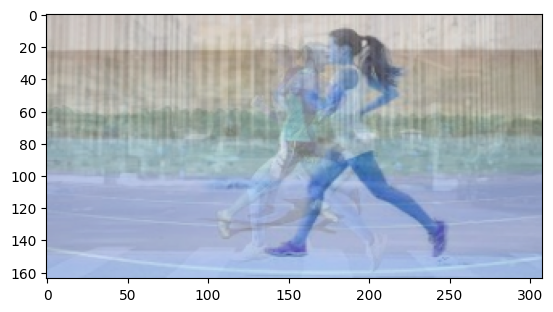

In [9]:

# import all image files with the .jpg extension
good_dir = 'D:/capstone-running-form/data/good_posture_avg image/'
images = glob.glob(os.path.join(good_dir, '*.jpg'))

image_data = []
for img in images:
    this_image = cv2.imread(img, 1)

    # Resize the image to the same size as the first image
    if len(image_data) > 0:
        resized_image = cv2.resize(this_image, dsize=(image_data[0].shape[1], image_data[0].shape[0]))
    else:
        resized_image = this_image

    image_data.append(resized_image)

avg_image = image_data[0]
for i in range(len(image_data)):
    if i == 0:
        pass
    else:
        alpha = 0.5 
        beta = 1.0 - alpha
        avg_image = cv2.addWeighted(image_data[i], alpha, avg_image, beta, 0.0)

cv2.imwrite('test.png', avg_image)
avg_image = cv2.imread('test.png')
plt.imshow(avg_image)
plt.show()

As expected, we can see that for a good posture, the ideal posture is upright.

#### 4. Calculating Angles

In [10]:
# Create a function to calculate 3 sets of coordinate points within a 2D space 

def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    # Calculate angles for all rows using vector operations
    radians = np.arctan2(c[:, 1] - b[:, 1], c[:, 0] - b[:, 0]) - np.arctan2(a[:, 1] - b[:, 1], a[:, 0] - b[:, 0])
    angles = np.abs(radians * 180.0 / np.pi)
    
    # Ensure angles are within [0, 360) degrees
    angles = np.where(angles > 180.0, 360 - angles, angles)
    
    return angles


In [11]:
# defining important landmarks for posture analysis
nose = df[['x1','y1']]

left_eye = df[['x3','y3']]
left_ear = df[['x8','y8']]
left_shoulder = df[['x12','y12']]
left_hip = df[['x24','y24']]
left_knee = df[['x26','y26']]

right_eye = df[['x6','y6']]
right_ear = df[['x9','y9']]
right_shoulder = df[['x13','y13']]
right_hip = df[['x25','y25']]
right_knee = df[['x27','y27']]

#### 5. Exploring difference in Mean & Standard Deviation of Landmark Coordinates for Good vs Bad postures

In [12]:
# Create list of more relevant landmark coordinate columns
landmark_coordinate_columns = [
    "x1", "y1", "x8", "y8", "x3", "y3", "x6", "y6", "x12", "y12", "x24", "y24", "x26", "y26", "x9", "y9", "x13", "y13", "x25", "y25", "x27", "y27"
]

# Get the landmark coordinates for the good and bad poses.
good_pose_landmarks = df[df['class'] == "Good"]
bad_pose_landmarks = df[df['class'] == "Bad"]

# Calculate the mean and standard deviation for the landmark coordinates in each group.
mean_good = good_pose_landmarks[landmark_coordinate_columns].mean().round(2)
std_good = good_pose_landmarks[landmark_coordinate_columns].std().round(2)
mean_bad = bad_pose_landmarks[landmark_coordinate_columns].mean().round(2)
std_bad = bad_pose_landmarks[landmark_coordinate_columns].std().round(2)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Landmark': landmark_coordinate_columns,
    'Mean Good': mean_good.values,
    'Std Good': std_good.values,
    'Mean Bad': mean_bad.values,
    'Std Bad': std_bad.values
})

# Display the DataFrame
print(results_df)

   Landmark  Mean Good  Std Good  Mean Bad  Std Bad
0        x1       0.50      0.11      0.47     0.11
1        y1       0.25      0.10      0.36     0.10
2        x8       0.50      0.11      0.48     0.13
3        y8       0.24      0.11      0.31     0.09
4        x3       0.50      0.11      0.48     0.11
5        y3       0.24      0.11      0.32     0.10
6        x6       0.50      0.11      0.47     0.11
7        y6       0.24      0.11      0.33     0.10
8       x12       0.50      0.11      0.48     0.18
9       y12       0.33      0.10      0.46     0.10
10      x24       0.50      0.11      0.47     0.20
11      y24       0.56      0.10      0.90     0.21
12      x26       0.50      0.12      0.52     0.12
13      y26       0.71      0.12      1.01     0.35
14       x9       0.49      0.11      0.46     0.13
15       y9       0.24      0.11      0.32     0.09
16      x13       0.49      0.11      0.43     0.16
17      y13       0.33      0.10      0.48     0.08
18      x25 

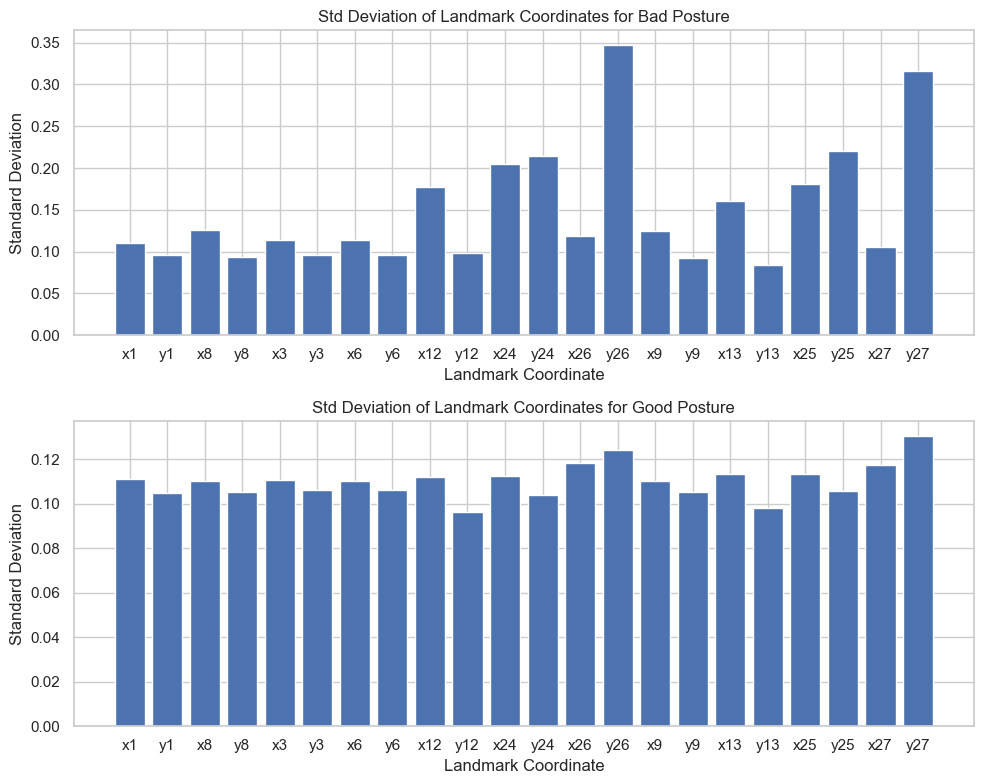

In [29]:

# Create a list of the landmark coordinate columns.
landmark_coordinate_columns = ["good_posture",
 "x1", "y1", "x8", "y8","x3", "y3", "x6", "y6", "x12", "y12", "x24", "y24", "x26", "y26", "x9", "y9", "x13", "y13", "x25", "y25", "x27", "y27"
]

# Filter the data by good_posture
good_posture_0 = df[df['good_posture'] == 0]
good_posture_1 = df[df['good_posture'] == 1]

# Calculate the standard deviation of the landmark coordinates for each column.
column_means_0 = good_posture_0[landmark_coordinate_columns].std(axis=0)
column_means_1 = good_posture_1[landmark_coordinate_columns].std(axis=0)
column_means_0 = column_means_0.drop("good_posture")
column_means_1 = column_means_1.drop("good_posture")

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].bar(column_means_0.index, column_means_0.values)
axs[0].set_xlabel("Landmark Coordinate")
axs[0].set_ylabel("Standard Deviation")
axs[0].set_title("Std Deviation of Landmark Coordinates for Bad Posture")

axs[1].bar(column_means_1.index, column_means_1.values)
axs[1].set_xlabel("Landmark Coordinate")
axs[1].set_ylabel("Standard Deviation")
axs[1].set_title("Std Deviation of Landmark Coordinates for Good Posture")

plt.tight_layout()
plt.show()


The standard deviation values of the landmark coordinates for good posture tend to be more consistent with each other (as shown in the 2nd chart) compared to the values for bad posture (1st chart). This is shown by the more varied values in chart 1. This suggests that good posture is characterized by a more consistent alignment of the body's landmarks, while bad posture may exhibit more variation in the positions of these landmark.

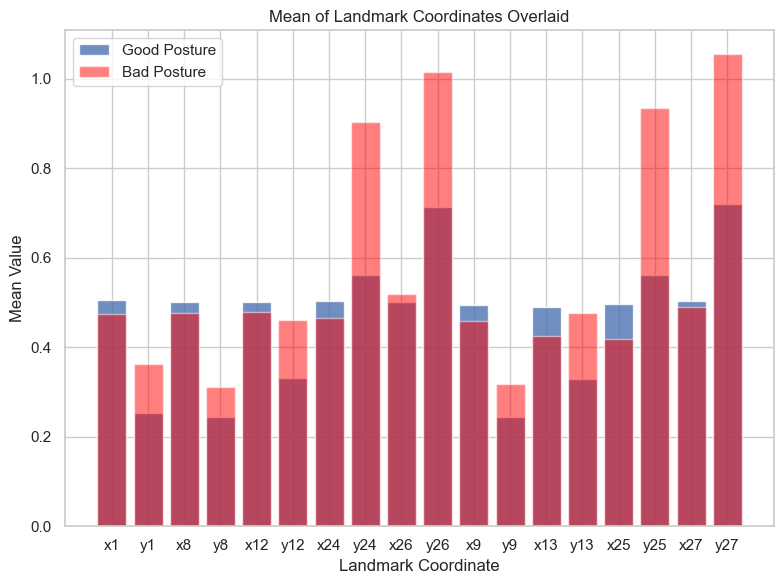

In [31]:

# Create a list of the landmark coordinate columns.
landmark_coordinate_columns = ["good_posture", "x1", "y1", "x8", "y8", "x12", "y12", "x24", "y24", "x26", "y26", "x9", "y9", "x13", "y13", "x25", "y25", "x27", "y27"
]

# Filter the data by good_posture
good_posture_0 = df[df['good_posture'] == 0]
good_posture_1 = df[df['good_posture'] == 1]

# Calculate the mean of the landmark coordinates for each column.
column_means_0 = good_posture_0[landmark_coordinate_columns].mean(axis=0)
column_means_1 = good_posture_1[landmark_coordinate_columns].mean(axis=0)
column_means_0 = column_means_0.drop("good_posture")
column_means_1 = column_means_1.drop("good_posture")

# Visualize the mean of the landmark coordinates for each column.
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the bars for the good_posture=1 group.
ax.bar(column_means_1.index, column_means_1.values, alpha=0.8, label='Good Posture')

# Plot the bars for the good_posture=0 group on top, with a higher alpha value.
ax.bar(column_means_0.index, column_means_0.values, color='red', alpha=0.5, label='Bad Posture')

ax.set_xlabel("Landmark Coordinate")
ax.set_ylabel("Mean Value")
ax.set_title("Mean of Landmark Coordinates Overlaid")

# Add a legend.
plt.legend()

plt.tight_layout()
plt.show()


Difference in values between good and bad posture came from landmark coordinates: y24, y26, y25 and y27 - these correspond to the hip and the knees. 
The angle of the Hip versus other body parts is a key angle in determining a good posture. Hence, this can explain why there was a higher mean values for these landmark coordinates.

#### 6. Calculating specific angles between landmarks to determine good or bad posture
Referring to a posture analysis conducted by Stanford University, the optimal posture is illustrated below: <br> <img src="https://ehs.stanford.edu/wp-content/uploads/postural-awareness-2.jpg"  style="height:400px" /> <br><br> Ideally, the angles between landmarks along a person's side should measure 180 degrees, resembling a straight line. In this section, we will be exploring exactly which angles to use.

##### 6.1 Eye-Shoulder-Hip

In [15]:
df['left_EyeSH'] = calculate_angle(left_eye,left_shoulder,left_hip)
df['right_EyeSH'] = calculate_angle(right_eye, right_shoulder, right_hip)
df[['class','left_EyeSH','right_EyeSH']]

,class,left_EyeSH,right_EyeSH
0,Bad,155.307020,172.507026
1,Bad,163.544608,169.504665
2,Bad,169.634487,163.841305
3,Bad,164.198492,163.581827
4,Bad,161.850092,166.930504
...,...,...,...
8364,Good,179.496542,156.895600
8365,Good,179.325181,156.072197
8366,Good,178.089347,155.679719
8367,Good,153.022944,174.212571


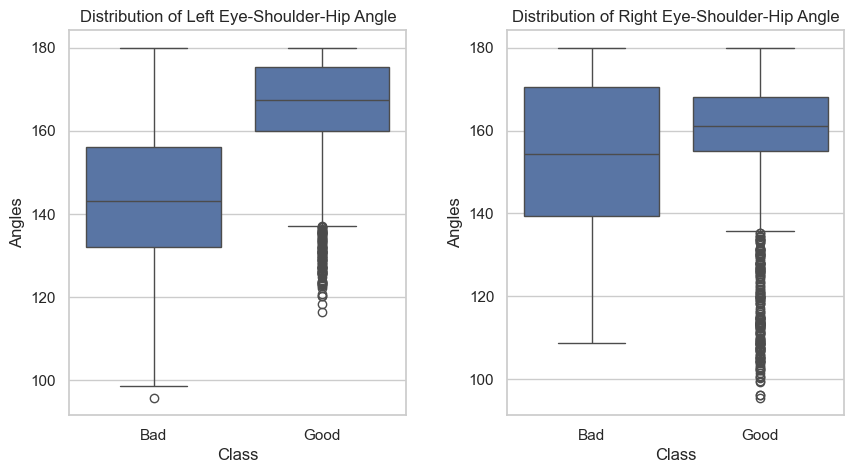

In [16]:
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create a box plot in each subplot
sns.boxplot(x='class', y='left_EyeSH', data=df, ax=ax1)
sns.boxplot(x='class', y='right_EyeSH', data=df, ax=ax2)

# Add labels and titles to the subplots
ax1.set_xlabel('Class')
ax1.set_ylabel('Angles')
ax1.set_title('Distribution of Left Eye-Shoulder-Hip Angle')

ax2.set_xlabel('Class')
ax2.set_ylabel('Angles')
ax2.set_title('Distribution of Right Eye-Shoulder-Hip Angle')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()

##### 6.2 Ear-Shoulder-Hip

In [17]:
df['left_ESH'] = calculate_angle(left_ear,left_shoulder,left_hip)
df['right_ESH'] = calculate_angle(right_ear, right_shoulder, right_hip)
df[['class','left_ESH','right_ESH']]

,class,left_ESH,right_ESH
0,Bad,163.510284,178.116644
1,Bad,173.068362,179.864711
2,Bad,178.625314,173.993331
3,Bad,173.384369,173.911822
4,Bad,170.893832,176.967896
...,...,...,...
8364,Good,174.313906,163.099885
8365,Good,173.078652,162.462970
8366,Good,171.908993,162.051717
8367,Good,160.705069,178.371101


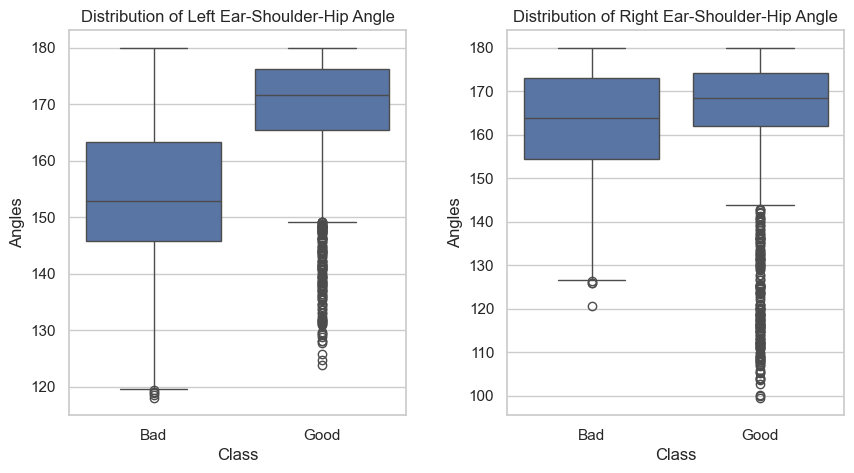

In [18]:
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create a box plot in each subplot
sns.boxplot(x='class', y='left_ESH', data=df, ax=ax1)
sns.boxplot(x='class', y='right_ESH', data=df, ax=ax2)

# Add labels and titles to the subplots
ax1.set_xlabel('Class')
ax1.set_ylabel('Angles')
ax1.set_title('Distribution of Left Ear-Shoulder-Hip Angle')

ax2.set_xlabel('Class')
ax2.set_ylabel('Angles')
ax2.set_title('Distribution of Right Ear-Shoulder-Hip Angle')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()


# eda do left side only
# plot images on notebook

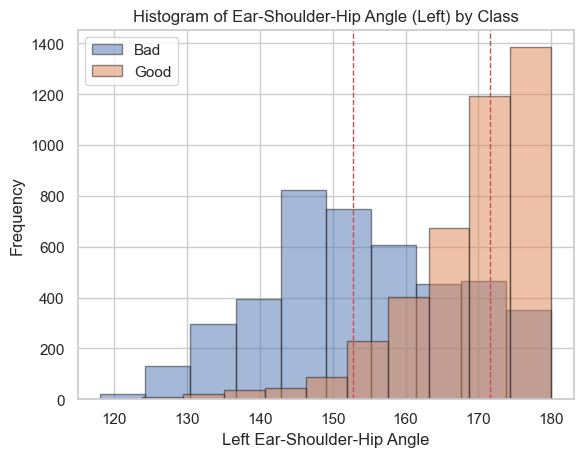

In [32]:
for class_label in df['class'].unique():
    class_df = df[df['class'] == class_label]
    counts, bins, patches = plt.hist(class_df['left_ESH'], edgecolor='k', alpha=0.5, label=class_label)

    # Calculate the median for the current class
    median_value = np.median(class_df['left_ESH'])

    # Draw a vertical line at the median position
    plt.axvline(median_value, color='r', linestyle='dashed', linewidth=1)

    # Store histogram data in the dictionary
    histograms[class_label] = {'counts': counts, 'bins': bins, 'median': median_value}

# Set the x- and y-axis labels
plt.xlabel('Left Ear-Shoulder-Hip Angle')
plt.ylabel('Frequency')

# Set the title of the plot
plt.title('Histogram of Ear-Shoulder-Hip Angle (Left) by Class')

# Add a legend to the plot
plt.legend()
plt.show()


The distribution and median of "Good" posture angles is closer to 180 degrees than the "Bad" posture angles.

##### 6.3 Nose-Shoulder-Hip

In [20]:
df['left_NSH'] = calculate_angle(nose,left_shoulder,left_hip)
df['right_NSH'] = calculate_angle(nose, right_shoulder, right_hip)
df[['class','left_NSH','right_NSH']]

,class,left_NSH,right_NSH
0,Bad,143.535033,161.939258
1,Bad,153.054688,159.226312
2,Bad,161.336623,153.260392
3,Bad,155.536213,153.985592
4,Bad,152.749715,157.711976
...,...,...,...
8364,Good,174.887152,148.161698
8365,Good,176.403710,147.421517
8366,Good,177.820674,147.042902
8367,Good,142.469704,169.214373


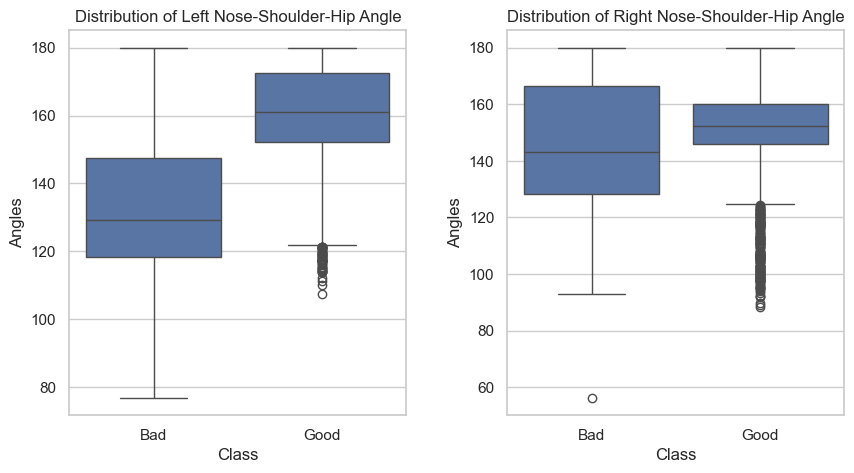

In [21]:
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create a box plot in each subplot
sns.boxplot(x='class', y='left_NSH', data=df, ax=ax1)
sns.boxplot(x='class', y='right_NSH', data=df, ax=ax2)

# Add labels and titles to the subplots
ax1.set_xlabel('Class')
ax1.set_ylabel('Angles')
ax1.set_title('Distribution of Left Nose-Shoulder-Hip Angle')

ax2.set_xlabel('Class')
ax2.set_ylabel('Angles')
ax2.set_title('Distribution of Right Nose-Shoulder-Hip Angle')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()

In [22]:
df.columns

Index(['class', 'x1', 'y1', 'z1', 'v1', 'x2', 'y2', 'z2', 'v2', 'x3',
       ...
       'y33', 'z33', 'v33', 'good_posture', 'left_EyeSH', 'right_EyeSH',
       'left_ESH', 'right_ESH', 'left_NSH', 'right_NSH'],
      dtype='object', length=140)

##### 6.4 Shoulder-Hip-Knee

In [23]:
df['left_SHK'] = calculate_angle(left_shoulder,left_hip, left_knee)
df['right_SHK'] = calculate_angle(right_shoulder, right_hip, right_knee)
df[['class','left_SHK','right_SHK']]

,class,left_SHK,right_SHK
0,Bad,147.515758,146.922322
1,Bad,149.645177,148.347381
2,Bad,150.563715,147.488250
3,Bad,155.709640,150.075273
4,Bad,158.154844,151.350972
...,...,...,...
8364,Good,178.568026,149.955519
8365,Good,179.207845,148.603204
8366,Good,177.911552,148.732710
8367,Good,145.753599,172.098057


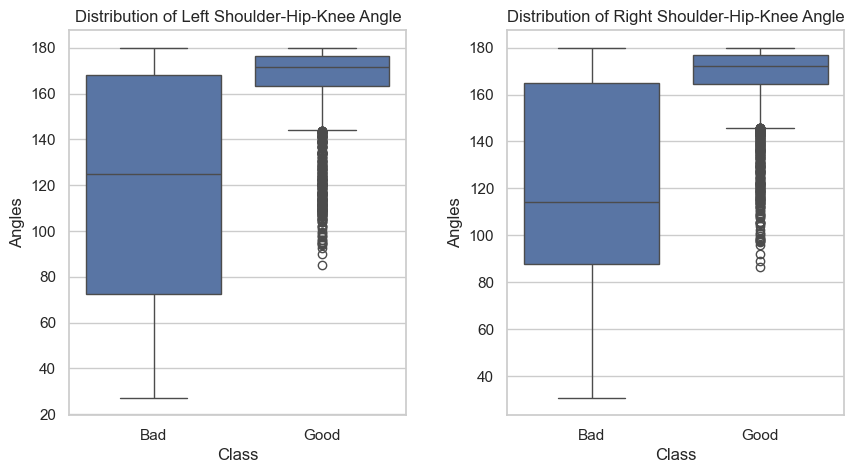

In [24]:
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create a box plot in each subplot
sns.boxplot(x='class', y='left_SHK', data=df, ax=ax1)
sns.boxplot(x='class', y='right_SHK', data=df, ax=ax2)

# Add labels and titles to the subplots
ax1.set_xlabel('Class')
ax1.set_ylabel('Angles')
ax1.set_title('Distribution of Left Shoulder-Hip-Knee Angle')

ax2.set_xlabel('Class')
ax2.set_ylabel('Angles')
ax2.set_title('Distribution of Right Shoulder-Hip-Knee Angle')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()

The four distinct angles identified between 6.1 and 6.4 exhibited a clear pattern: "Good" posture angles were concentrated around 180 degrees (straight line), as expected, as evident from the short boxplots with medians close to 180 degrees. This indicates minimal deviation from the ideal posture. Interestingly, the boxplot distributions for the "good" and "bad" classes were more similar for right side angles compared to left side angles. This observation can be attributed to the training data primarily capturing humans running from right to left, leading to a higher proportion of left side angles, hence more accurate data observed.

#### 7. Correlation Heatmap for calculated angles

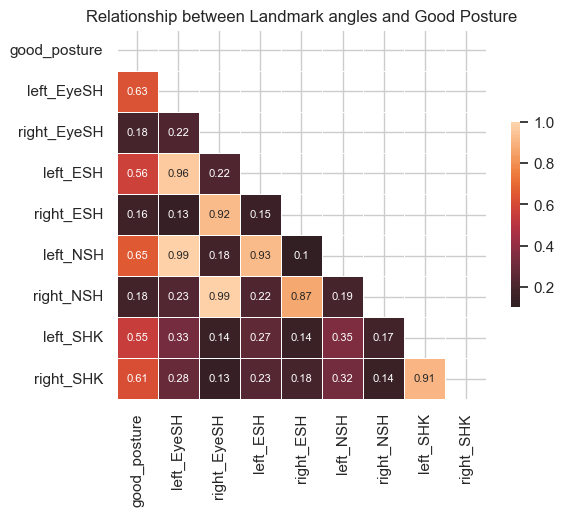

In [25]:
# select calculated angles
selected_columns = ['good_posture','left_EyeSH', 'right_EyeSH','left_ESH', 'right_ESH', 'left_NSH', 'right_NSH','left_SHK','right_SHK']

# Calculate the correlation matrix for selected columns
correlation_matrix = df[selected_columns].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, vmax=1, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot_kws={"fontsize": 8})

plt.title('Relationship between Landmark angles and Good Posture')
plt.show()

In [26]:
df.head()

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,v33,good_posture,left_EyeSH,right_EyeSH,left_ESH,right_ESH,left_NSH,right_NSH,left_SHK,right_SHK
0,Bad,0.597514,0.330045,-0.046739,0.999786,0.595233,0.314657,-0.039935,0.999435,0.594381,...,0.995285,0,155.307020,172.507026,163.510284,178.116644,143.535033,161.939258,147.515758,146.922322
1,Bad,0.603381,0.325570,-0.049170,0.999806,0.601188,0.310604,-0.040726,0.999489,0.600242,...,0.994957,0,163.544608,169.504665,173.068362,179.864711,153.054688,159.226312,149.645177,148.347381
2,Bad,0.614878,0.315903,-0.031407,0.999825,0.613352,0.302009,-0.020730,0.999540,0.612598,...,0.995270,0,169.634487,163.841305,178.625314,173.993331,161.336623,153.260392,150.563715,147.488250
3,Bad,0.624886,0.308227,-0.035477,0.999842,0.623481,0.295145,-0.026631,0.999585,0.622720,...,0.995534,0,164.198492,163.581827,173.384369,173.911822,155.536213,153.985592,155.709640,150.075273
4,Bad,0.636889,0.295799,-0.043732,0.999856,0.634686,0.282637,-0.032385,0.999624,0.634024,...,0.995753,0,161.850092,166.930504,170.893832,176.967896,152.749715,157.711976,158.154844,151.350972


In [27]:
# save dataframe with newly created columns for modelling in Notebook III.

df.to_csv('model_df.csv', index=False)